## Resample data into Healpix

1. Create HEALPix grid 
2. Extract data if it is still in a zip file
3. Interpolate from initial points to Healpix grid. Uses linear interpolation
4. Save file

In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import zipfile
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import xesmf as xe

import os
from pathlib import Path
import healpy as hp

In [2]:
input_dir = '../data/equiangular/5.625deg/'
output_dir = '../data/healpix/5.625deg/'
nside = 16
n_pixels = 12*(nside**2)

In [3]:
# New HEALPix grid
n_pixels = 12*(nside**2)
hp_lon, hp_lat = hp.pix2ang(nside, np.arange(n_pixels), lonlat=True, nest=True)
lon_idx = xr.DataArray(hp_lon, dims=["lon"])
lat_idx = xr.DataArray(hp_lat, dims=["lat"])

In [4]:
all_files = os.listdir(input_dir)
all_files

['toa_incident_solar_radiation',
 'total_precipitation',
 'potential_vorticity',
 'temperature_850',
 'vorticity',
 'geopotential_500',
 '10m_v_component_of_wind',
 'constants',
 'u_component_of_wind',
 'total_cloud_cover',
 'specific_humidity',
 '2m_temperature',
 '10m_u_component_of_wind',
 'temperature',
 'v_component_of_wind',
 'all_5.625deg.zip',
 'relative_humidity',
 'geopotential']

In [5]:
#all_files = os.listdir(input_dir)
all_files = ['geopotential']

#all_files = ['toa_incident_solar_radiation']
for f in all_files:
    print('Working on ', f)
    
    # Check if file has been unzip
    if not os.path.isfile(input_dir + f + '/' + f + '_1979_5.625deg.nc') and not os.path.isfile(input_dir + f + '/' + f + '_5.625deg.nc'):
        print('Data Extraction...')
        # extract data in the same folder 
        with zipfile.ZipFile(input_dir + f + '/' + f + '_5.625deg.zip',"r") as zip_ref:
            zip_ref.extractall(input_dir + f + '/')
            
    # Interpolate
    print('Interpolation...')
    ds = xr.open_mfdataset(input_dir + f + '/*.nc', combine='by_coords')
    
    #linear interpolation
    interp_ds = ds.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node') 
    interp_ds = interp_ds.assign_coords(node=np.arange(n_pixels))
    
    # Create out folder
    out_path =  output_dir + f + "/"
    Path(out_path).mkdir(parents=True, exist_ok=True)
    
    # Save
    out_filename = f + '_5.625deg.nc'
    interp_ds.to_netcdf(out_path + out_filename)

Working on  geopotential
Data Extraction...
Interpolation...


#### Try to use xESMF to perform the regridding

https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview

Use similar procedure to the one described in [Weather Bench](https://github.com/pangeo-data/WeatherBench/blob/master/src/regrid.py) to perform regridding with xEMSF

Regridding function: [xESMF Regridding](https://xesmf.readthedocs.io/en/latest/user_api.html?highlight=regridder#regridder)

### TODO: 
Right now it generates a grid of 3072x3072 pixels by doing the cross-product of all latitude and longitude values we provide. Not what we want. Find a way to specify the values without using a regular grid. 

Update [15.07]: xESMF does not handle grids that are not quadrilinear... look for an alternative

In [4]:
ds_aux = xr.open_mfdataset(input_dir + 'toa_incident_solar_radiation' + '/*.nc', combine='by_coords')

Create input and output grids

In [14]:
# input grid
grid_in = xr.Dataset(
        {'lat': (['lat'], ds_aux.lat),'lon': (['lon'], ds_aux.lon)}
    )

# output grid
grid_out = xr.Dataset(
        {'lat': ('lat', lat_idx),'lon': ('lon', lon_idx)}
    )

In [15]:
method = 'bilinear'
reuse_weights = True

regridder = xe.Regridder(
        grid_in, grid_out, method, reuse_weights=reuse_weights,
    )

Reuse existing file: bilinear_32x64_3072x3072.nc


In [17]:
ds_in = ds_aux

In [18]:
# regrid 
ds_list = []
chunk_size = 500
n_chunks = len(ds_in.time) // chunk_size + 1
for i in range(n_chunks):
    ds_small = ds_in.isel(time=slice(i*chunk_size, (i+1)*chunk_size))
    ds_list.append(regridder(ds_small).astype('float64'))
ds_out = xr.concat(ds_list, dim='time')

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable tisr as the horizontal

In [24]:
# select only nodes we are interested in
ds_list_out = []
for i in range(n_pixels):
    print('\r{}'.format(i), end="")
    ds_list_out.append(ds_out.isel({'lat':[i], 'lon':[i]}).drop_vars(['lon','lat']))

3071

In [25]:
# create array
ds_out_sampled = xr.concat(ds_list_out, dim='node')

In [26]:
# assign node as coordinates
ds_out_sampled = ds_out_sampled.assign_coords(node=np.arange(n_pixels))

In [27]:
# drop dimensions with single value
ds_out_sampled = ds_out_sampled.squeeze()

In [28]:
# add latitude and longitude information
ds_out_sampled = ds_out_sampled.assign_coords(lat=('node', lat_idx))
ds_out_sampled = ds_out_sampled.assign_coords(lon=('node', lon_idx))

In [29]:
# match previous order of dimensions
ds_out_sampled.transpose()

,Array,Chunk
Bytes,8.62 GB,4.00 kB
Shape,"(350633, 3072)","(500, 1)"
Count,13660455 Tasks,2276352 Chunks
Type,float64,numpy.ndarray


In [9]:
ds_in

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350633, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [19]:
ds_out

,Array,Chunk
Bytes,26.47 TB,37.75 GB
Shape,"(350633, 3072, 3072)","(500, 3072, 3072)"
Count,2343 Tasks,741 Chunks
Type,float64,numpy.ndarray


Original grid

Plot of values on the original grid. Dots in red represent the new grid.

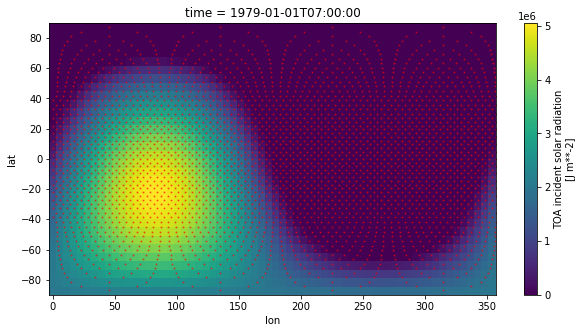

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
ds_aux.tisr.isel(time=0).plot(ax=ax)
ax.plot(lon_idx.values, lat_idx.values, 'o', alpha=0.5, c='red', markersize=1)
plt.show()

Interpolated with xESMF

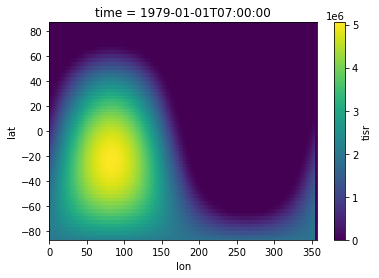

In [30]:
ax = ds_out.tisr.isel(time=0).sortby(['lon','lat']).plot()

Interpolated with xArray

In [22]:
# original
ds_linear = ds_in.interp(lon=('node', lon_idx), lat=('node', lat_idx)).interpolate_na(dim='node', method='nearest')
ds_linear = ds_linear.assign_coords(node=np.arange(n_pixels))

In [23]:
ds_linear

<xarray.Dataset>
Dimensions:  (node: 3072, time: 350633)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
    lat      (node) float64 2.388 4.78 4.78 7.181 ... -7.181 -4.78 -4.78 -2.388
    lon      (node) float64 45.0 47.81 42.19 45.0 ... 315.0 317.8 312.2 315.0
  * node     (node) int64 0 1 2 3 4 5 6 7 ... 3065 3066 3067 3068 3069 3070 3071
Data variables:
    tisr     (time, node) float64 dask.array<chunksize=(8753, 3072), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-07 20:42:10 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

This does **NOT** work

```python
ds_list_out = []
for i in range(3072):
    print('\r{}'.format(i), end="")
    ds_list_out.append(ds_out.isel({'lat':[i], 'lon':[i]}))
ds_out_sampled = xr.concat(ds_list_out, dim='time')
```

Compare format of both methods

In [ ]:
ds_out

In [30]:
ds_linear

<xarray.Dataset>
Dimensions:  (node: 3072, time: 350633)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
    lat      (node) float64 2.388 4.78 4.78 7.181 ... -7.181 -4.78 -4.78 -2.388
    lon      (node) float64 45.0 47.81 42.19 45.0 ... 315.0 317.8 312.2 315.0
  * node     (node) int64 0 1 2 3 4 5 6 7 ... 3065 3066 3067 3068 3069 3070 3071
Data variables:
    tisr     (time, node) float64 dask.array<chunksize=(8753, 3072), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-07 20:42:10 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

#### Explore differences between both methods

Check if the interpolated values have differences

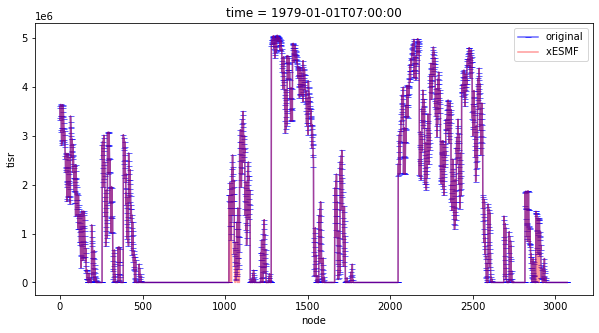

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
ds_linear.tisr.isel(time=0).plot(ax=ax, alpha=0.6, c='b', marker='_')
ds_out_sampled.tisr.isel(time=0).plot(ax=ax, alpha=0.4, c='r')
plt.legend(['original', 'xESMF '])
plt.show()

In [35]:
diff = ds_linear.tisr.isel(time=0) - ds_out_sampled.tisr.isel(time=0)

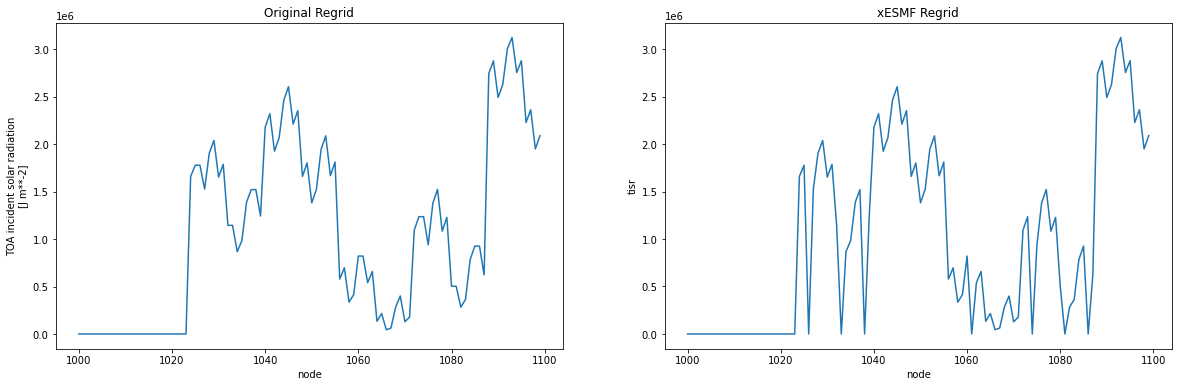

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ds_linear.tisr.isel(time=0, node=np.arange(1000, 1100)).plot(ax=ax[0])
ds_out_sampled.tisr.isel(time=0, node=np.arange(1000, 1100)).plot(ax=ax[1])

ax[0].set_title('Original Regrid')
ax[1].set_title('xESMF Regrid')

plt.show()

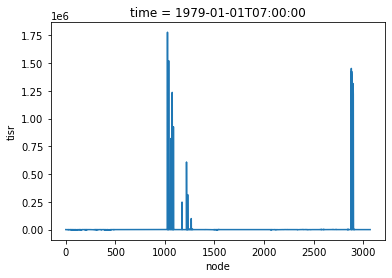

In [36]:
diff.plot()